# Job Boards for Data Science





<a id="toc"></a>

<br>
<hr style="background-color: black; padding: 1px;">
<br>

<h2>Table of Contents</h2>

<br>

<ol>
    <h3><li><a href="#section1">Defining functions to get job postings</a></li></h3>
    <br>
    <h3><li><a href="#section2">Analyzing job postings</a></li></h3>
    <br>
    <h3><li><a href="#section3">Analyzing job descriptions</a></li></h3>
</ol>

### Import needed libraries

In [345]:
# web scraping
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support.ui import WebDriverWait as wait
from selenium.webdriver.chrome.options import Options
chrome_options = Options()
chrome_options.set_headless(headless=False) # decides whether to show the chrome window while executing web search

# parsing web pages
from bs4 import BeautifulSoup

# plotting pacakges
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# ignore matplotlib/seaborn deprecation warning... it just looks ugly
import warnings
warnings.filterwarnings("ignore", message="The 'normed' kwarg is deprecated, and has been ")

# assortment of other libraries
import re
import time
from nltk.corpus import stopwords
import string
from collections import Counter
import pandas as pd
import numpy as np

<div align="right">
    <a href="#toc">back to top</a>
</div>
<a id='section1'></a>

### Define important functions

**Web scrape Glassdoor**

In [257]:
def get_glassdoor_data(job_search_term="Data Science", location_search_term="California", all_pages=True):
    
    notification_blocked = False
    pages_searched = 0
    all_jobs = 0
    job_descriptions = []
    job_pages = []

    browser = webdriver.Chrome(chrome_options=chrome_options)

    browser.get('https://www.glassdoor.com/index.htm')

    search_job = browser.find_element_by_name('sc.keyword')  # Find the search box
    search_job.clear()
    search_job.send_keys(job_search_term)

    location = browser.find_element_by_id('LocationSearch')
    location.clear()
    location.send_keys(location_search_term)
    wait(browser, 3)
    location.send_keys(Keys.RETURN)

    while True:
    
        pages_searched += 1
        
        time.sleep(3) # wait for new page to load
    
        job_pages.append(browser.page_source) # data collection step

        jobs = browser.find_elements_by_class_name('jl')

        total_jobs = len(jobs)
        all_jobs += total_jobs
        jobs_counter = 0

        for job in jobs:

            try: 
                if not notification_blocked:
                    try:
                        wait(browser, 3)
                        close_button = browser.find_element_by_class_name('mfp-close')
                        close_button.click()
                        print("Alert escaped")
                        notification_blocked = True
                    except:
                        print("no alert")

                job.click()

                time.sleep(2) # wait for job description to load

                job_descriptions.append(browser.page_source) # data collection step
                jobs_counter += 1
            except:
                print("Issue clicking on job:")
                print(job)

        if total_jobs != jobs_counter:
            print("Only {0} jobs mined out of {1}.".format(jobs_counter, total_jobs))
        
        if pages_searched % 10 == 0:
            print("Mined {} jobs".format(jobs_counter))
    
        try:
            next_page = browser.find_element_by_class_name('next')
            next_page.click()
        except:
            break;
    
    browser.quit()
    
    print("Number of pages searched = {}".format(pages_searched))
    print("Number of jobs mined = {}".format(all_jobs))
    
    return(job_descriptions, job_pages)

**Parse the search results pages**

In [220]:
def parse_glassdoor_jobs(job_pages):
    
    data_dict = {"company":[], "position":[], "location":[], "date":[]}
    
    for page in job_pages:
        
        soup = BeautifulSoup(page, 'html.parser')
        joblistings = soup.find_all('li', class_="jl") 
    
        for i in range(len(joblistings)):
            try:
                data_dict["date"].append(joblistings[i].find('span', class_="hideHH nowrap").get_text())
            except:
                data_dict["date"].append("N/A")
            try:
                data_dict["location"].append(joblistings[i].find('span', class_="subtle loc").get_text())
            except:
                data_dict["location"].append("N/A")
            try:    
                data_dict["company"].append(joblistings[i].find('div', class_="flexbox empLoc").find_next('div').text.split(' ' + chr(8211) + ' ')[0].strip())
            except:
                data_dict["company"].append("N/A")
            try:
                data_dict["position"].append(joblistings[i].find('div', class_="flexbox").get_text())
            except:
                data_dict["position"].append("N/A")
        
    df = pd.DataFrame.from_dict(data_dict)    
    
    return df
        

**Parse the job descriptions for key word counts**

In [229]:
def parse_top_terms_glassdoor(job_descriptions):
    
    stop_words = set(stopwords.words('english'))

    job_tokens = []
    
    for job in job_descriptions:
        soup = BeautifulSoup(job, 'html.parser')
        words = soup.find('div', id='JobDescriptionContainer')
        words = words.text.strip().replace('\n', ' ').translate(string.punctuation)
        words = re.sub(r'[^\w\s]', '', words)
        filtered_words = list(filter(lambda w: not w in stop_words, words.lower().split()))
        job_tokens = job_tokens + filtered_words
        
    counted_words = Counter(job_tokens)
    
    return(counted_words)

### Now let's get our data!

In [258]:
job_descriptions, job_pages = get_glassdoor_data()

no alert
Alert escaped
Mined 30 jobs
Issue clicking on job:
<selenium.webdriver.remote.webelement.WebElement (session="ed1efe859ed73a4f2fc6187029eed42c", element="0.42148129833726866-31")>
Only 30 jobs mined out of 31.
Mined 0 jobs
Number of pages searched = 20
Number of jobs mined = 571


In [259]:
print("Number of job descriptions = {}".format(len(job_descriptions)))
print("Number of job search result pages = {}".format(len(job_pages)))

Number of job descriptions = 570
Number of job search result pages = 20


<div align="right">
    <a href="#toc">back to top</a>
</div>
<a id='section2'></a>

### Analyzing Job Postings

(Using the function we built earlier)

In [260]:
df = parse_glassdoor_jobs(job_pages)

In [261]:
df.head(n=5)

,company,date,location,position
0,Agoda,N/A,"San Francisco, CA",Data Science Manager - Bangkok
1,Glassdoor,4 days ago,"Mill Valley, CA","Lead Data Scientist, Decision Science"
2,Datastax,6 days ago,"Santa Clara, CA",Data Science Intern
3,StubHub,8 days ago,"San Francisco, CA",Revenue Modeling & Data Science Lead
4,M Theory Solutions,20 days ago,"Palo Alto, CA",Data Scientist / Predictive Modeler


In [262]:
df.shape

(571, 4)

Great, we have almost 600 job postings. Let's convert the 'date' column to something that will be easier to analyze.

In [307]:
set(df['date'].tolist())

{' 10 days ago',
 ' 11 days ago',
 ' 12 days ago',
 ' 13 days ago',
 ' 14 days ago',
 ' 15 days ago',
 ' 16 days ago',
 ' 17 days ago',
 ' 18 days ago',
 ' 19 days ago',
 ' 20 days ago',
 ' 21 days ago',
 ' 22 days ago',
 ' 23 days ago',
 ' 24 days ago',
 ' 25 days ago',
 ' 26 days ago',
 ' 27 days ago',
 ' 28 days ago',
 ' 29 days ago',
 ' 30+ days ago',
 ' 4 days ago',
 ' 5 days ago',
 ' 6 days ago',
 ' 7 days ago',
 ' 8 days ago',
 ' 9 days ago',
 'N/A'}

We see that all time is in days, but we have N/As and 30 days or more is just 30+. Let's make them just a number without the words "days ago".

In [308]:
def convert_date(date):
    if date == 'N/A':
        date = None
    else:
        date = re.search('\d+', date).group(0)
    return date

In [310]:
df['date'] = df['date'].apply(convert_date)

In [311]:
df.head(n=5)

,company,date,location,position
0,Agoda,None,"San Francisco, CA",Data Science Manager - Bangkok
1,Glassdoor,4,"Mill Valley, CA","Lead Data Scientist, Decision Science"
2,Datastax,6,"Santa Clara, CA",Data Science Intern
3,StubHub,8,"San Francisco, CA",Revenue Modeling & Data Science Lead
4,M Theory Solutions,20,"Palo Alto, CA",Data Scientist / Predictive Modeler


**Plotting the distribution of dates:**

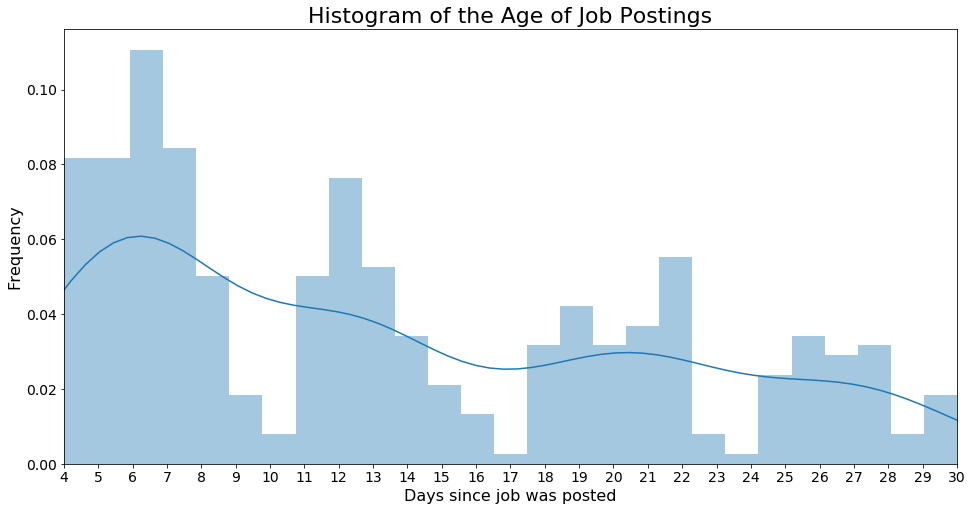

In [388]:
# get the data ready
dates = [int(x) for x in df['date'].tolist() if x is not None]
min_date = np.min(dates)
max_date = np.max(dates)
num_bins = len(set(dates))

fig, ax = plt.subplots(figsize=(16,8))
major_ticks = np.arange(min_date,max_date+1,1)
sns.distplot(dates, bins=num_bins, ax=ax)
ax.set_title("Histogram of the Age of Job Postings", fontsize=22);
ax.set_ylabel("Frequency", fontsize=16);
ax.set_xlabel("Days since job was posted", fontsize=16);
ax.tick_params(labelsize=14);
ax.set_xticks(major_ticks, minor=False);
plt.xlim(min_date,max_date);

**Two things to notice:**

1) Most job postings are less than a week old and drop off steadily over time. This is likely why Glassdoor just says "30+" when a job posting is more than 30 days old.

2) The data appears to cycle. Without looking into the data to confirm, the obvious interpretation is that employers aren't as likely to post jobs on the weekend.

<div align="right">
    <a href="#toc">back to top</a>
</div>
<a id='section3'></a>

### Analyzing words in job postings

In [263]:
counted_words = parse_top_terms_glassdoor(job_descriptions)

In [284]:
words = []
counts = []

for word in counted_words.keys():
    words.append(word)
    counts.append(counted_words[word])
    
df_word_counts = pd.DataFrame({"word":words, "count":counts})

In [382]:
df_word_counts.shape

(14674, 2)

We scraped thousands of unique words from the job descriptions, however, even though we filtered out simple words like "the", "a", "of", most words in the list are not exactly data science skills:

In [383]:
df_word_counts= df_word_counts.sort_values("count", ascending=False)
df_word_counts.head(n=20)

,count,word
10896,5327,data
8718,2350,experience
3622,1656,science
10780,1610,team
4897,1397,business
11965,1186,work
2044,1096,learning
14459,894,product
1914,878,machine
13163,840,analytics


Terms like "data science" that were split into two tokens both rank highly (not interesting / useful to us) and words like "experience" may say something interesting about data science job postings, perhaps that most require significant experience OR it might just be a common heading in job descriptions as might be "responsibilities" or "education".

At any rate, it would be more interesting to see the relative 

**Define a list of words of interest to filter on**

In [380]:
data_science_words = ['python','sql','r','hadoop','spark','d3.js','hive','matlab','excel',
                      'nosql','aws','c','java','javascript','php','scala','tableau','cassandra',
                      'etl','javascript','mahout','redis','redshift','machine','learning','deep',
                      'tensorflow','keras','matplotlib','Ruby','Pig','mongodb','mysql','pandas',
                      'numpy','scipy','linux','windows'
                     ]

In [368]:
df_ds_words = df_word_counts[df_word_counts["word"].isin(data_science_words)]

In [375]:
df_ds_words = df_ds_words.sort_values("count", ascending=False)

In [381]:
df_ds_words.head(n=10)

,count,word
2044,1096,learning
1914,878,machine
9139,420,python
13091,317,sql
5765,269,r
1840,256,deep
6724,179,spark
8485,140,hadoop
14306,116,java
10745,94,aws


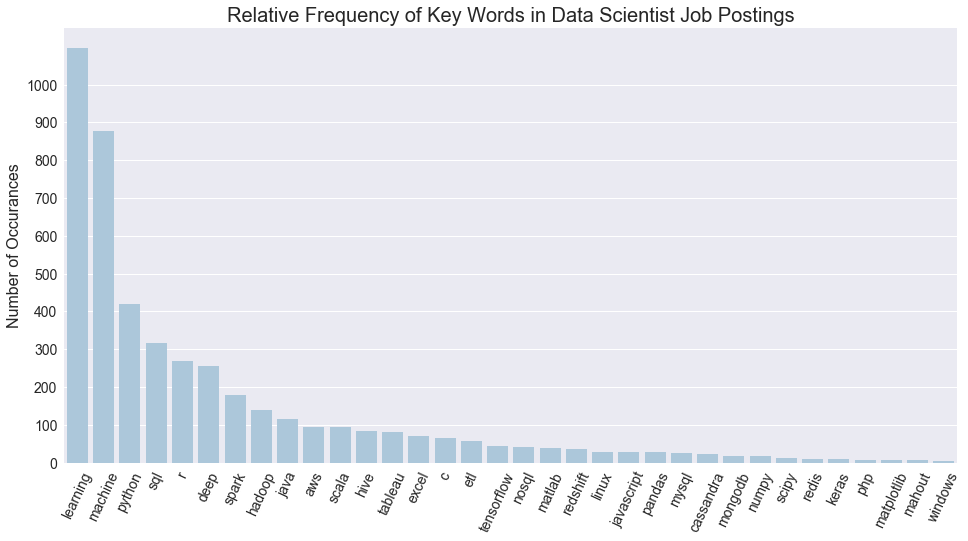

In [401]:
sns.set(style='darkgrid')
plt.figure(figsize=(16,8))
ax = sns.barplot(x="word",y="count", color="#a5c8e1", data=df_ds_words);
ax.set_xticklabels(ax.get_xticklabels(),rotation=65);
ax.set_title("Relative Frequency of Key Words in Data Scientist Job Postings", fontsize=20);
ax.set_ylabel("Number of Occurances", fontsize=16);
ax.set_xlabel("");
ax.tick_params(labelsize=14);
major_ticks = np.arange(0,1001,100)
ax.set_yticks(major_ticks, minor=False);
# ax.grid(b=True, which='major', color='w', linewidth=1.0);

***

<div align="center">
    <a href="#toc">back to top</a>
</div>